# Ο Πέτρος και ο Λύκος: Ρεαλιστικό Περιβάλλον

Στην περίπτωσή μας, ο Πέτρος μπορούσε να κινείται σχεδόν χωρίς να κουράζεται ή να πεινάει. Σε έναν πιο ρεαλιστικό κόσμο, θα έπρεπε να κάθεται και να ξεκουράζεται από καιρό σε καιρό, καθώς και να τρέφεται. Ας κάνουμε τον κόσμο μας πιο ρεαλιστικό, εφαρμόζοντας τους παρακάτω κανόνες:

1. Μετακινούμενος από το ένα μέρος στο άλλο, ο Πέτρος χάνει **ενέργεια** και αποκτά κάποια **κόπωση**.
2. Ο Πέτρος μπορεί να αποκτήσει περισσότερη ενέργεια τρώγοντας μήλα.
3. Ο Πέτρος μπορεί να απαλλαγεί από την κόπωση ξεκουραζόμενος κάτω από το δέντρο ή στο γρασίδι (δηλαδή περπατώντας σε ένα σημείο του ταμπλό που έχει δέντρο ή γρασίδι - πράσινο πεδίο).
4. Ο Πέτρος πρέπει να βρει και να σκοτώσει τον λύκο.
5. Για να σκοτώσει τον λύκο, ο Πέτρος πρέπει να έχει συγκεκριμένα επίπεδα ενέργειας και κόπωσης, διαφορετικά θα χάσει τη μάχη.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

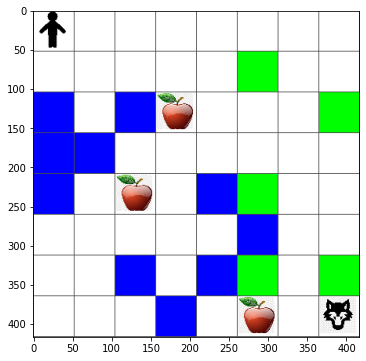

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Ορισμός κατάστασης

Στους νέους κανόνες του παιχνιδιού μας, πρέπει να παρακολουθούμε την ενέργεια και την κόπωση σε κάθε κατάσταση του πίνακα. Έτσι, θα δημιουργήσουμε ένα αντικείμενο `state` που θα περιέχει όλες τις απαραίτητες πληροφορίες για την τρέχουσα κατάσταση του προβλήματος, συμπεριλαμβανομένης της κατάστασης του πίνακα, των τρεχόντων επιπέδων ενέργειας και κόπωσης, καθώς και του αν μπορούμε να νικήσουμε τον λύκο όταν βρισκόμαστε σε τελική κατάσταση:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Ας προσπαθήσουμε να λύσουμε το πρόβλημα χρησιμοποιώντας τυχαία βήματα και να δούμε αν θα πετύχουμε:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Συνάρτηση Ανταμοιβής

Η συνάρτηση ανταμοιβής είναι ένα κρίσιμο στοιχείο για την εκπαίδευση ενός ενισχυτικού μαθησιακού αλγορίθμου. Καθορίζει πώς αξιολογείται κάθε ενέργεια που λαμβάνει ο πράκτορας, οδηγώντας τον προς την επίτευξη του στόχου.

### Τι είναι η Συνάρτηση Ανταμοιβής;

Η συνάρτηση ανταμοιβής είναι μια μαθηματική συνάρτηση που επιστρέφει μια αριθμητική τιμή (η ανταμοιβή) με βάση την κατάσταση του περιβάλλοντος και την ενέργεια που εκτελεί ο πράκτορας. Αυτή η τιμή καθοδηγεί τον πράκτορα να μάθει ποια ενέργεια είναι η καλύτερη σε κάθε κατάσταση.

[!NOTE] Η σωστή σχεδίαση της συνάρτησης ανταμοιβής είναι κρίσιμη για την επιτυχία του πράκτορα.

### Βασικές Αρχές

1. **Ευθυγράμμιση με τον στόχο**: Η συνάρτηση ανταμοιβής πρέπει να αντικατοπτρίζει τον τελικό στόχο του πράκτορα. Για παράδειγμα, αν ο στόχος είναι να φτάσει σε έναν προορισμό, η ανταμοιβή μπορεί να βασίζεται στην απόσταση που απομένει.
2. **Αποφυγή ανεπιθύμητων συμπεριφορών**: Μια κακώς σχεδιασμένη συνάρτηση μπορεί να οδηγήσει σε ανεπιθύμητες ή απρόβλεπτες συμπεριφορές. Για παράδειγμα, αν η ανταμοιβή βασίζεται μόνο στην ταχύτητα, ο πράκτορας μπορεί να αγνοήσει την ασφάλεια.
3. **Απλότητα**: Μια απλή συνάρτηση ανταμοιβής είναι συχνά πιο αποτελεσματική και ευκολότερη στην κατανόηση.

### Παραδείγματα Συνάρτησης Ανταμοιβής

#### Παράδειγμα 1: Πλοήγηση

Σε ένα περιβάλλον πλοήγησης, η συνάρτηση ανταμοιβής μπορεί να οριστεί ως εξής:

- Αν ο πράκτορας φτάσει στον στόχο, δώσε ανταμοιβή +100.
- Αν ο πράκτορας συγκρουστεί με εμπόδιο, δώσε ανταμοιβή -50.
- Για κάθε βήμα που δεν φτάνει στον στόχο, δώσε ανταμοιβή -1.

#### Παράδειγμα 2: Παιχνίδι

Σε ένα παιχνίδι, η συνάρτηση ανταμοιβής μπορεί να περιλαμβάνει:

- Αν ο πράκτορας κερδίσει, δώσε ανταμοιβή +500.
- Αν ο πράκτορας χάσει, δώσε ανταμοιβή -500.
- Για κάθε πόντο που κερδίζει, δώσε ανταμοιβή +10.

[!TIP] Δοκιμάστε διαφορετικές παραλλαγές της συνάρτησης ανταμοιβής για να βρείτε αυτή που λειτουργεί καλύτερα για το πρόβλημά σας.

### Συχνά Λάθη

- **Υπερβολική πολυπλοκότητα**: Μια πολύπλοκη συνάρτηση μπορεί να δυσκολέψει τον πράκτορα να μάθει.
- **Ασυνέπεια**: Αν η συνάρτηση ανταμοιβής δεν είναι συνεπής, ο πράκτορας μπορεί να μπερδευτεί.
- **Ανεπαρκής ανταμοιβή**: Αν οι ανταμοιβές είναι πολύ μικρές ή σπάνιες, ο πράκτορας μπορεί να μην μάθει αποτελεσματικά.

[!WARNING] Να είστε προσεκτικοί με τις αρνητικές ανταμοιβές. Αν είναι πολύ ισχυρές, μπορεί να αποθαρρύνουν τον πράκτορα από την εξερεύνηση.

### Συμπέρασμα

Η συνάρτηση ανταμοιβής είναι το θεμέλιο για την επιτυχία ενός ενισχυτικού μαθησιακού συστήματος. Επενδύστε χρόνο για να τη σχεδιάσετε σωστά, λαμβάνοντας υπόψη τον στόχο, τις πιθανές ανεπιθύμητες συμπεριφορές και την απλότητα.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Αλγόριθμος Q-Learning

Ο πραγματικός αλγόριθμος μάθησης παραμένει σχεδόν αμετάβλητος, απλώς χρησιμοποιούμε `state` αντί για απλή θέση του πίνακα.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

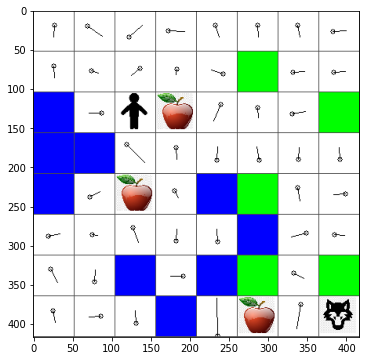

In [11]:
m.plot(Q)

## Αποτελέσματα

Ας δούμε αν καταφέραμε να εκπαιδεύσουμε τον Πέτρο να πολεμήσει τον λύκο!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Τώρα βλέπουμε πολύ λιγότερες περιπτώσεις πνιγμού, αλλά ο Πέτρος δεν μπορεί πάντα να σκοτώσει τον λύκο. Προσπαθήστε να πειραματιστείτε και δείτε αν μπορείτε να βελτιώσετε αυτό το αποτέλεσμα παίζοντας με τις υπερπαραμέτρους.


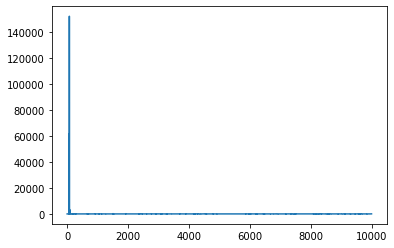

In [13]:
plt.plot(lpath)


---

**Αποποίηση Ευθύνης**:  
Αυτό το έγγραφο έχει μεταφραστεί χρησιμοποιώντας την υπηρεσία αυτόματης μετάφρασης [Co-op Translator](https://github.com/Azure/co-op-translator). Παρόλο που καταβάλλουμε κάθε προσπάθεια για ακρίβεια, παρακαλούμε να έχετε υπόψη ότι οι αυτόματες μεταφράσεις ενδέχεται να περιέχουν σφάλματα ή ανακρίβειες. Το πρωτότυπο έγγραφο στη μητρική του γλώσσα θα πρέπει να θεωρείται η αυθεντική πηγή. Για κρίσιμες πληροφορίες, συνιστάται επαγγελματική ανθρώπινη μετάφραση. Δεν φέρουμε ευθύνη για τυχόν παρεξηγήσεις ή εσφαλμένες ερμηνείες που προκύπτουν από τη χρήση αυτής της μετάφρασης.
